In [1]:
from util.SongDataStructure import *
from util.pitch_interval_estimation import *
import numpy as np
import json
from matplotlib import pyplot as plt
import os
from util.ioUtil import get_audio_from_video
from scipy.interpolate import interp1d, splrep, splev
from models.vowel_modification_detector import vowel_mod_detector
vowel_mod = vowel_mod_detector()
import copy


## Input Block

In [49]:
dir = "C:/Users/evan1/Desktop/music_companion"
file_name_template = "someone_like_you"
raw_script_path = os.path.join(dir, file_name_template, file_name_template+"_raw.TextGrid")
processed_script_path = os.path.join(dir, file_name_template, file_name_template+".TextGrid")
audio_path = os.path.join(dir, file_name_template, file_name_template+"_chorus_vocals.wav")
text_script_path = os.path.join(dir, file_name_template, file_name_template+"_chorus_vocals.txt")


output_template = "jali_MVP"
spike_width = 0.5
speech_vowel_threshold = 0.3
vowel_blend_distance = 0.3
vowel_blend_magnitude = 0.95

# Pre-process data

In [53]:
lyric = Minimal_song_data_structure(audio_path, text_script_path)
lyric.compute_self_phoneme_alignment()
path_to_file, file_name = os.path.split(raw_script_path)
lyric.write_textgrid(path_to_file, file_name.split(".")[0]) 

['>', 'N', 'EH', 'V', 'ER', '>', 'M', 'AY', 'N', 'D', '>', 'AY', 'L', '>', 'F', 'AY', 'N', 'D', '>', 'S', 'AH', 'M', 'W', 'AH', 'N', '>', 'L', 'AY', 'K', '>', 'Y', 'UW', '>', 'AY', '>', 'W', 'IH', 'SH', '>', 'N', 'AH', 'TH', 'IH', 'NG', '>', 'B', 'AH', 'T', '>', 'DH', 'AH', '>', 'B', 'EH', 'S', 'T', '>', 'F', 'AO', 'R', '>', 'Y', 'UW', '>', 'T', 'UW', '>', 'D', 'OW', 'N', 'T', '>', 'F', 'ER', 'G', 'EH', 'T', '>', 'M', 'IY', '>', 'AY', '>', 'B', 'EH', 'G', 'D', '>', 'AY', '>', 'R', 'IH', 'M', 'EH', 'M', 'B', 'ER', '>', 'Y', 'UW', '>', 'S', 'EH', 'D', '>', 'S', 'AH', 'M', 'T', 'AY', 'M', 'Z', '>', 'IH', 'T', '>', 'L', 'AE', 'S', 'T', 'S', '>', 'IH', 'N', '>', 'L', 'AH', 'V', '>', 'B', 'AH', 'T', '>', 'S', 'AH', 'M', 'T', 'AY', 'M', 'Z', '>', 'IH', 'T', '>', 'HH', 'ER', 'T', 'S', '>', 'IH', 'N', 'S', 'T', 'EH', 'D', '>', 'N', 'AH', 'TH', 'IH', 'NG', '>', 'K', 'AH', 'M', 'P', 'EH', 'R', 'Z', '>', 'N', 'OW', '>', 'W', 'ER', 'IY', 'Z', '>', 'AO', 'R', '>', 'K', 'EH', 'R', 'Z', '>', 'R', 'IH'

In [7]:
VOICED = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH', 'EY', 'IH', 'IY', 'OW', 'OY', 'UH', 'UW', "ER"])
CMU2VISEME = {"AA":"Ah", "AO":"Ah", "AY":"Ah", "AW":"Ah","AE":"Aa",
              "EY":"Aa","UH":"Uh", "UW":"U","IH": "Ih","IY": "Ih","EH": "Eh","HH": "Eh","UH": "Eh","AH": "Eh",
              "ER": "Eh","OW":"Oo","OY":"Oh","R":"R","D":"LNTD","T": "LNTD","L":"LNTD","N":"LNTD","NG":"LNTD",
              "F":"FV","V":"FV","B":"BP","M":"M","P":"BP","CH":"ShChZh","SH":"ShChZh","ZH":"ShChZh",
              "S": "SZ", "Z": "SZ","DH":"Th", "TH":"Th","G":"GK", "K":"GK","Y":"Y","JH":"J","W":"W",}
VOWELS_SLIDERS_JALI = set(['Ih_pointer', 'Ee_pointer', 'Eh_pointer', 'Aa_pointer', 'U_pointer', 'Uh_pointer'
                           , 'Oo_pointer', 'Oh_pointer', 'Schwa_pointer', 'Eu_pointer', "Ah_pointer"])
CONSONANTS_SLIDERS_JALI = set(["M_pointer", "BP_pointer", "JY_pointer", "Th_pointer", "ShChZh_pointer", "SZ_pointer", "GK_pointer", "LNTD_pointer", "R_pointer", "W_pointer", "FV_pointer"])
CONSONANTS_SLIDERS_NOJAW_JALI = set(["Ya_pointer", "Ja_pointer", "Ra_pointer", "FVa_pointer", "LNTDa_pointer", "Ma_pointer", "BPa_pointer", "Wa_pointer", "Tha_pointer", "GKa_pointer"])
JALI_SLIDERS_SET = set.union(VOWELS_SLIDERS_JALI, CONSONANTS_SLIDERS_JALI, CONSONANTS_SLIDERS_NOJAW_JALI)

CMU2VISEME = {"AA":"Ah", "AO":"Ah", "AY":"Ah", "AW":"Ah","AE":"Eh",
              "EY":"Eh","UH":"Ah", "UW":"U","IH": "Ee","IY": "Ee","EH": "Eh","HH": "Eh","UH": "U","AH": "Eh",
              "ER": "Eh","OW":"Oo","OY":"Oo","R":"R","D":"LNTD","T": "LNTD","L":"LNTD","N":"LNTD","NG":"LNTD",
              "F":"FV","V":"FV","B":"BP","M":"M","P":"BP","CH":"ShChZh","SH":"ShChZh","ZH":"ShChZh",
              "S": "SZ", "Z": "SZ","DH":"Th", "TH":"Th","G":"GK", "K":"GK","Y":"Y","JH":"J","W":"W",}

dip_percentage = {"U_pointer":1.05, "Oo_pointer":0.95, "Ah_pointer":0.9, "Eh_pointer":0.9, 
                  "Ee_pointer":1.1, "LNTD_pointer":0.9, "M_pointer":0.9}


cmu_sets = CMU_phonemes_dicts()
jali_sets = JALI_visemes_dicts()
def generate_basic_viseme_curve(start, end, value, sustain=1, decay = 0.75, onset=0.1, offset=0):
    if end - start < 0.1:
        end = start + 0.1
    interval = []
    interval.append([start-onset, 0, "bound"])
    # second point is when the belting starts 
    interval.append([start, 1 * value, "internal"])
    # third point emphasizes decay, it happens 75% down the interval
    if sustain < 1:
        interval.append([start + sustain * (end - start), decay * value, "internal"])
        # last point is where the furrowing ends
        interval.append([end+offset, 0, "bound"])
    elif sustain == 1:
        interval.append([end, value, "internal"])
        # last point is where the furrowing ends
        interval.append([end+offset, 0, "bound"])
    return interval
def get_kth_neighbour(input_list, i, k):
    if i+k < 0 or i+k >= len(input_list):
        return None
    return input_list[i+k]
def difference_of_ctrl_pts(ctrl_pts1, ctrl_pts2):
    if len(ctrl_pts1) != len(ctrl_pts2):
        print(False)
        return False
    for i in range(0, len(ctrl_pts1)):
        if len(ctrl_pts1[i]) != len(ctrl_pts2[i]):
            print(False)
            return False
    for i in range(0, len(ctrl_pts1)):
        for j in range(0, len(ctrl_pts1[i])):
            if ctrl_pts1[i][j][0] != ctrl_pts2[i][j][0] or ctrl_pts1[i][j][1] != ctrl_pts2[i][j][1]:
                print(False)
                return False
    return True

def plot_viseme_curve(viseme_curve:Viseme_curve, viseme_slider_name:str):
    v_list = viseme_curve.viseme_list[-1]
    ctrl_pts = viseme_curve.viseme_ctrl_pts[-1]
    
    x = []
    y = []
    for i in range(0, len(v_list)):
        if v_list[i] == viseme_slider_name:
            for k in range(0, len(ctrl_pts[i])):
                x.append(ctrl_pts[i][k][0])
                y.append(ctrl_pts[i][k][1])
#     tck = splrep(x, y, s=0)
    A = [x, y]
    A = np.array(A)
    A = A[::, A[0,].argsort()[::-1]]
    x = A[0]
    y = A[1]
    
#     x_range = np.arange(x.min(), x.max(), 0.01)
#     y_interp = splev(x_range, tck, der=0)
#     plt.plot(x_range, y_interp)
    plt.plot(x, y)
    return

# using tanh function to get a smooth curve
def Viseme_A(peak=None, lowest=None):
    if not peak is None:
        total = np.log((1+peak)/(1-peak))/2
        b = np.log((1+lowest)/(1-lowest))/2
        a = total-b
    else:
        peak = 0.99
        lowest = 0.8
        total = np.log((1+peak)/(1-peak))/2
        b = np.log((1+lowest)/(1-lowest))/2
        a = total-b
    def fn(val, val_max, val_min, max_val = 8):
        val = (val - val_min) / (val_max - val_min)
        if val_min == val_max:
            val = 1
#         print(val)
#         return (lowest + val * ((peak - lowest)))*max_val
        return np.tanh((val)*a+b) * max_val
#         return (np.exp(val * 8)/np.exp(8) * (peak-lowest) + lowest) * max_val
    return fn
viseme_A = Viseme_A()

In [54]:
# load file for Jali
lyric = Minimal_song_data_structure(audio_path, text_script_path, processed_script_path)
# lyric = Minimal_song_data_structure(os.path.join(dir, file_name_template + ".pt"),
#                                     None,
#                                     os.path.join(dir, file_name_template + ".TextGrid"),
#                                     use_torch=True)

# break the thing into sentence structures (if possible)
sentences = []
current_sentence = []
for i in range(0, len(lyric.phoneme_list)):
    if lyric.phoneme_list[i] == "EOS_tag":
        sentences.append(current_sentence)
        current_sentence = []
    else:
        current_sentence.append(i)
        if i == len(lyric.phoneme_list) - 1:
            sentences.append(current_sentence)
sentences = sentences[1:] 
# sentence stores the indexes
if len(sentences) == 0:
    sentences = [list(range(0, len(lyric.phoneme_list)))]
phoneme_list = lyric.phoneme_list
phoneme_interval = lyric.phoneme_intervals

### Animating Consonant and Vowel visemes with Musical Articulation and relative Pitch Change (Ver original)

### Ver 2

In [55]:
def merge_intervals(slopes, intervals, freq_interp, xs, min_length=0.3, flatness_threshold=60):
    flat_intervals = []
    flat_slopes = []
    pass_next = False
    for i in range(0, len(slopes)):
        if pass_next:
            pass_next = False
            continue
        if abs(slopes[i]) <= flatness_threshold:
            if xs[intervals[i][1]] - xs[intervals[i][0]] >= min_length:
                flat_intervals.append([xs[intervals[i][0]], xs[intervals[i][1]]])
                flat_slopes.append(slopes[i])
            else:
                next_index = min(i+1, len(slopes)-1) 
                if next_index == i:
                    continue
                next_slope = slopes[next_index]
                next_interval = intervals[next_index]
                if xs[next_interval[0]] - xs[intervals[i][1]] <= 0.07 and abs(next_slope) <= flatness_threshold and (
                freq_interp((xs[next_interval[0]] + xs[next_interval[1]])/2.0) - 
                    freq_interp((xs[intervals[i][0]] + xs[intervals[i][1]])/2.0)) <= 50:
                    if xs[next_interval[1]] - xs[intervals[i][0]] >= min_length:
                        flat_intervals.append([xs[intervals[i][0]], xs[next_interval[1]]])
                        pass_next = True
                        flat_slopes.append(next_slope)
    return flat_intervals, flat_slopes        

In [56]:
## phone_id = sentence[i]
## return a pair of lists, [[singing_viseme, singing_curve, singing_phoneme], [speech_viseme, speech_curve, speech_phoneme]]
def generate_pitch_sensitive_viseme_curve(lyric, phoneme_list, phoneme_interval, phone_id):
    xI, yI = lyric.get_I_interval(phoneme_interval[phone_id])
    xf, yf = lyric.get_f_interval(phoneme_interval[phone_id])
    xF, yF = lyric.get_F1_interval(phoneme_interval[phone_id])
    length_of_interval = xI[-1] - xI[0] 
    if length_of_interval <= speech_vowel_threshold: # if the vowel is approximately a speech vowel, then it is handled like speech
        onset = 0.12
        offset = 0.12
        if phoneme_list[phone_id] in cmu_sets.lip_heavy:
            onset = 0.16
            offset = 0.16
        value = 7
        sustain = 0.75
        decay = 0.75
        curve = generate_basic_viseme_curve(phoneme_interval[phone_id][0], phoneme_interval[phone_id][1], value, sustain=sustain, 
                                    decay = decay, onset=onset, offset=offset)
        singing_stuff = [CMU2VISEME[phoneme_list[phone_id]] + "_pointer", curve, phoneme_list[phone_id]]
        speaking_stuff = [CMU2VISEME[phoneme_list[phone_id]] + "_pointer", curve, phoneme_list[phone_id]]
        return [singing_stuff, speaking_stuff]
    else:
        onset = 0.12
        offset = 0.12
        if phoneme_list[phone_id] in cmu_sets.lip_heavy:
            onset = 0.16
            offset = 0.16
        value = 7
        sustain = 0.75
        decay = 0.75
        control_pts = generate_basic_viseme_curve(phoneme_interval[phone_id][0], phoneme_interval[phone_id][1], value, sustain=sustain, 
                                    decay = decay, onset=onset, offset=offset)
        control_pts_with_pitch_change = []
#                 vib = get_vib(yf-savgol_filter(yf, 29, 1), xf, lyric.dt)
        vib = lyric.compute_vibrato_intervals(yf-savgol_filter(yf, 29, 1), xf, lyric.dt)
        vib_interval_indexs = lyric.get_subarrays_indexes_from_time_interval(vib, xf)
        for vib_int in vib_interval_indexs:
            yf[vib_int[0]:vib_int[1]] = yf[vib_int[0]:vib_int[1]].mean()

        slopes_f, intervals_f = efficient_piece_wise_linear_intervals(xf, yf)
        kpx_f, kpy_f = get_key_points(xf, yf, intervals_f, slopes_f)
        flat_intervals, flat_slopes = merge_intervals(slopes_f, intervals_f, interp1d(xf, yf), xf)
        # onset and offset of these would be the same as regular vowels 
        control_pts_with_pitch_change.append([phoneme_interval[phone_id][0] - onset, 0, "bound"])
        # here I will determine the average pitch when singing this vowel. Which is used to 
        avg_pitch = 0
        total_weight = 0
        pitch_values = []
        for si in range(0, len(slopes_f)):
            if abs(slopes_f[si]) <= threshold_slope:
                avg_pitch = avg_pitch + (yf[intervals_f[si][0]] * (intervals_f[si][1] - intervals_f[si][0]))
                pitch_values.append(yf[intervals_f[si][0]])
                total_weight = total_weight + (intervals_f[si][1] - intervals_f[si][0])
        if avg_pitch == 0:
                avg_pitch = yf.mean()
                total_weight = 1
        pitch_values = np.array(pitch_values)
        avg_pitch = avg_pitch / total_weight
        start = 0
        first_points_of_intervals = []
        interp_pitch = interp1d(kpx_f, kpy_f)
        # now find the first key point - i.e. the beginning of the first plateau
        # the first key point is defined as the point where a plateau first appears 
        # it can also be the first point that reaches the same pitch as the first plateau
        # this ensures that undetected vibrato will not mess up with the timing
        # and cause the mouth to open too slowly 

        for si in range(0, len(flat_intervals)):
            current_interval_x_range = np.arange(flat_intervals[si][0], flat_intervals[si][1], 0.01)
            current_interval_f_range = interp_pitch(current_interval_x_range)
            start = si
            # make sure the search do not exceed the interpolation range
            end_x_search = min(flat_intervals[si][0], kpx_f[-1])
            begin_x_search = max(intervals_f[0][0], kpx_f[0])
            x_range = np.arange(begin_x_search, end_x_search, 0.01)
            f_range = interp_pitch(x_range)
            first_val = interp_pitch(flat_intervals[si][0])
            for ssi in range(0, x_range.shape[0]-1):
                if ((f_range[ssi] < first_val) and  (f_range[ssi+1] >= first_val) 
                    or (f_range[ssi] >= first_val) and  (f_range[ssi+1] < first_val)):
                    end_x_search = x_range[ssi]
                    break
            val0 = viseme_A(current_interval_f_range.max(), yf.max(), yf.min())
            height_ratio = dip_percentage[CMU2VISEME[phoneme_list[phone_id]] + "_pointer"]
            val1 = viseme_A(current_interval_f_range.max(), yf.max(), yf.min()) * height_ratio
            control_pts_with_pitch_change.append([flat_intervals[si][0], val0, "internal"])
            if len(flat_intervals) > 1:
#                         dif = max((flat_intervals[si][1] - flat_intervals[si][0]) * 0.9, flat_intervals[si+1][0] - flat_intervals[si][1]- 0.025)
                dif = flat_intervals[si+1][0] - flat_intervals[si][0]- 0.1
            else:
#                         dif = max((flat_intervals[si][1] - flat_intervals[si][0]) * 0.9, flat_intervals[si][1] - flat_intervals[si][0]- 0.025)
                dif = flat_intervals[si][1] - flat_intervals[si][0]- 0.1
            control_pts_with_pitch_change.append([flat_intervals[si][0] + dif, val1, "internal"])                 
            break
        # now determine intermediate key-points that correlates with lipshape
        for si in range(start+1, len(flat_intervals)):
            current_interval_x_range = np.arange(flat_intervals[si][0], flat_intervals[si][1], 0.01)
            current_interval_f_range = interp_pitch(current_interval_x_range)

            val0 = viseme_A(current_interval_f_range.max(), yf.max(), yf.min())
            height_ratio = dip_percentage[CMU2VISEME[phoneme_list[phone_id]] + "_pointer"]
#                     height_ratio = 0.9
            val1 = viseme_A(current_interval_f_range.max(), yf.max(), yf.min()) * height_ratio
            if len(flat_intervals) - 1> si:
                # if it's not the last interval
                # dif = max((flat_intervals[si][1] - flat_intervals[si][0]) * 0.9, flat_intervals[si+1][0] - flat_intervals[si][1]- 0.025)
                dif = flat_intervals[si+1][0] - flat_intervals[si][0]- 0.1
            else:
                # if it is the last interval
#                         dif = max((flat_intervals[si][1] - flat_intervals[si][0]) * 0.9, flat_intervals[si][1] - flat_intervals[si][0]- 0.025)
                dif = flat_intervals[si][1] - flat_intervals[si][0]- 0.1
            prev_interval_end_pt_x = control_pts_with_pitch_change[-1][0]
            prev_interval_end_pt_y = min(control_pts_with_pitch_change[-1][1], val0)
#                     prev_interval_end_pt_y = min(control_pts_with_pitch_change[-1][1], val0) * dip_percentage[CMU2VISEME[phoneme_list[sentence[i]]] + "_pointer"]

            control_pts_with_pitch_change.append([(flat_intervals[si][0] + prev_interval_end_pt_x)/2.0, prev_interval_end_pt_y, "internal_ph"])    
            control_pts_with_pitch_change.append([flat_intervals[si][0], val0, "internal"])
#                     if len(flat_intervals) - 1 == si:
#                         control_pts_with_pitch_change.append([flat_intervals[si][0] + dif, val0 * 0.8, "internal"])
#                     else:
#                         control_pts_with_pitch_change.append([flat_intervals[si][0] + dif, val1, "internal_ph"])
            control_pts_with_pitch_change.append([flat_intervals[si][0] + dif, val1, "internal"])
        control_pts_with_pitch_change.append([phoneme_interval[phone_id][1] + offset, 0, "bound"])
        # if I cannot find any flat intervals in the vowel, then this step is spared
        if len(control_pts_with_pitch_change) < 4:
            onset = 0.12
            offset = 0.12
            if phoneme_list[phone_id] in cmu_sets.lip_heavy:
                onset = 0.16
                offset = 0.16
            value = 7
            sustain = 0.75
            decay = 0.75
            control_pts_with_pitch_change = generate_basic_viseme_curve(phoneme_interval[phone_id][0], phoneme_interval[phone_id][1], value, sustain=sustain, 
                                        decay = decay, onset=onset, offset=offset)
            extended_vowel_list.append(CMU2VISEME[phoneme_list[phone_id]] + "_pointer")
            extended_vowel_intervals.append(phoneme_interval[phone_id])
        else:
            for item in flat_intervals:
                extended_vowel_list.append(CMU2VISEME[phoneme_list[phone_id]] + "_pointer_pitch_change")
                extended_vowel_intervals.append(item)
        control_pts_with_pitch_change_final = []
        skip = False
        control_pts_with_pitch_change.sort(key=lambda x:x[0])
        for mi in range(0, len(control_pts_with_pitch_change)):
            if skip:
                skip = False
                continue
            if control_pts_with_pitch_change[mi][2] == "internal_ph":
                if mi != len(control_pts_with_pitch_change)-2:
                    new_pt = [control_pts_with_pitch_change[mi+1][0], 
                              control_pts_with_pitch_change[mi+1][1],
                              "internal"]
                    control_pts_with_pitch_change_final.append(new_pt)
                    skip = True
                else:
                    new_pt = [control_pts_with_pitch_change[mi][0], 
                              control_pts_with_pitch_change[mi][1],
                               "internal"]
                    control_pts_with_pitch_change_final.append(new_pt)  
            else:
                control_pts_with_pitch_change_final.append(control_pts_with_pitch_change[mi])
                
        singing_stuff = [CMU2VISEME[phoneme_list[phone_id]] + "_pointer", control_pts_with_pitch_change_final, phoneme_list[phone_id]]
        speaking_stuff = [CMU2VISEME[phoneme_list[phone_id]] + "_pointer", control_pts, phoneme_list[phone_id]]
        return [singing_stuff, speaking_stuff]
        

In [57]:
visemes_sing = Viseme_curve()
visemes_sing.new_pass()
visemes_speak = Viseme_curve()
visemes_speak.new_pass()

extended_vowel_intervals = []
extended_vowel_list = []

# animate only vowels and see how it goes
max_activation = 8
# threshold_slope = 200 # for formants
threshold_slope = 60 # for pitch

for sentence in sentences:
    for i in range(0, len(sentence)):
        # skip the misc symbols in the sentence
        if phoneme_list[sentence[i]] in VOICED: # basically vowels
            singing_stuff, speaking_stuff = generate_pitch_sensitive_viseme_curve(lyric, phoneme_list, phoneme_interval, sentence[i])
            visemes_sing.add(singing_stuff[0], singing_stuff[1], singing_stuff[2])
            visemes_speak.add(speaking_stuff[0], speaking_stuff[1], speaking_stuff[2])
                
        ### Dealing with consonants here. I'm just going to insert them between without too much modification
        ### it will about the same as pure Jali
        elif phoneme_list[sentence[i]] in cmu_sets.consonants:
#             if phoneme_list[sentence[i]] in cmu_sets.voiced:
            onset = 0.12
            offset = 0.12
            if phoneme_list[sentence[i]] == "HH" or phoneme_list[sentence[i]] in cmu_sets.sibilant:
                viseme_jali = CMU2VISEME[phoneme_list[sentence[i]]] + "_pointer"
            else:
                viseme_jali = CMU2VISEME[phoneme_list[sentence[i]]] + "a_pointer"
            if viseme_jali in jali_sets.lip_heavy:
                onset = 0.16
                offset = 0.16
            start = phoneme_interval[sentence[i]][0]
            end = phoneme_interval[sentence[i]][1]
            if (end - start) <= 0.1:
                value = 6
                sustain = 0.75
                decay = 0.75
            elif (end - start) <= 0.3:
                value = 6
                sustain = 0.75
                decay = 0.75
            else:
                value = 8
                sustain = 0.75
                decay = 0.75
            if phoneme_list[sentence[i]] in cmu_sets.lip_closer:
                value = 10
            viseme_curve = generate_basic_viseme_curve(start, end, value, sustain=sustain, decay=decay, onset=onset, offset=offset)
            visemes_sing.add(viseme_jali, viseme_curve, phoneme_list[sentence[i]])
            visemes_speak.add(viseme_jali, viseme_curve, phoneme_list[sentence[i]])
            # add jaw component to voiced consonants if it's sufficiently voiced
            prev_vowel = -1
            for si in range(i-1, -1, -1):
                if phoneme_list[si] in cmu_sets.vowels:
                    prev_vowel = si
                    break
            if (phoneme_list[sentence[i]] in set(["N", "NG"]) 
                and phoneme_interval[sentence[i]][1] - phoneme_interval[sentence[i]][0] > 1/20
                and (phoneme_interval[sentence[i]][0] - phoneme_interval[sentence[prev_vowel]][1] > 0.1 
                    or prev_vowel == -1
                    )):
                singing_stuff, speaking_stuff = generate_pitch_sensitive_viseme_curve(lyric, phoneme_list, phoneme_interval, sentence[i])
                visemes_sing.add(singing_stuff[0], singing_stuff[1], singing_stuff[2])
                visemes_speak.add(speaking_stuff[0], speaking_stuff[1], speaking_stuff[2])
            elif (phoneme_list[sentence[i]] == "L"
                and phoneme_interval[sentence[i]][1] - phoneme_interval[sentence[i]][0] > 1/20):
                singing_stuff, speaking_stuff = generate_pitch_sensitive_viseme_curve(lyric, phoneme_list, phoneme_interval, sentence[i])
                visemes_sing.add(singing_stuff[0], singing_stuff[1], singing_stuff[2])
                visemes_speak.add(speaking_stuff[0], speaking_stuff[1], speaking_stuff[2])

In [58]:
for i in range(0, len(visemes_sing.viseme_ctrl_pts[-1])):
    print(visemes_sing.viseme_list[-1][i], visemes_sing.viseme_ctrl_pts[-1][i])

LNTDa_pointer [[1.4315000000000002, 0, 'bound'], [1.5515, 6, 'internal'], [1.6838206238554938, 4.5, 'internal'], [1.8479274984739917, 0, 'bound']]
LNTD_pointer [[1.4315000000000002, 0, 'bound'], [1.5515, 7, 'internal'], [1.6838206238554938, 5.25, 'internal'], [1.8479274984739917, 0, 'bound']]
Eh_pointer [[1.6079274984739915, 0, 'bound'], [1.7279274984739916, 7, 'internal'], [1.855551730759878, 5.25, 'internal'], [2.01809314152184, 0, 'bound']]
FVa_pointer [[1.7780931415218402, 0, 'bound'], [1.89809314152184, 10, 'internal'], [1.97309314152184, 7.5, 'internal'], [2.11809314152184, 0, 'bound']]
Eh_pointer [[1.8692533074403306, 0, 'bound'], [1.9892533074403305, 7, 'internal'], [2.1578996143895375, 5.25, 'internal'], [2.3341150500392733, 0, 'bound']]
Ma_pointer [[2.124501772012103, 0, 'bound'], [2.244501772012103, 10, 'internal'], [2.3195017720121034, 7.5, 'internal'], [2.4645017720121034, 0, 'bound']]
Ah_pointer [[2.154888493984933, 0, 'bound'], [2.274888493984933, 7, 'internal'], [2.4936

In [59]:
# enforce co-articulation rules of consonants for speech visemes
i = 0;
viseme_list = copy.deepcopy(visemes_speak.viseme_list[-1])
pure_phoneme_list = copy.deepcopy(visemes_speak.pure_phoneme[-1])
viseme_intervals = copy.deepcopy(visemes_speak.viseme_ctrl_pts[-1])
visemes_speak.new_pass()
while i < len(viseme_list):
    increment = 1
    i_next = min(i + 1, len(viseme_list)-1)
    if ((viseme_list[i_next] == viseme_list[i] and not viseme_list[i] in jali_sets.vowels) or (pure_phoneme_list[i] == "HH" and pure_phoneme_list[i_next] in cmu_sets.vowels)
        and viseme_intervals[i][-1][0] >= viseme_intervals[i_next][0][0]):
        # remove repeated vowels or consonants
        int_curr = viseme_intervals[i]
        int_next = viseme_intervals[i_next]
        viseme_interval = [int_curr[0], [int_curr[1][0], max(int_curr[1][1], int_next[1][1]), int_curr[1][2]]]
        for interv in int_next[2:]:
            viseme_interval.append(interv)                
        visemes_speak.add(viseme_list[i_next], copy.deepcopy(viseme_interval), pure_phoneme_list[i_next])
#         if viseme_list[i_next] in jali_sets.lip_rounder:
#             visemes_sing(jali_sets.lip_rounder_no_jaw_dict[viseme_list[i_next]], viseme_interval, pure_phoneme_list[i_next])
        increment = 2
    elif viseme_list[i] in jali_sets.lip_heavy:
        # if the viseme is a lip-heavy viseme, the it is voice simutaneously as nearby labial dental and bilabials 
        current_interval = copy.deepcopy(viseme_intervals[i])
        if not get_kth_neighbour(viseme_list, i, -1) is None:
            if current_interval[0][0] <= viseme_intervals[i-1][-1][0] - lyric.dt and viseme_intervals[i-1][-1][0] in jali_sets.lip_rounder:
                current_interval[0][0] = viseme_intervals[i-1][0][0]
                current_interval[1][0] = viseme_intervals[i-1][1][0]
        if not get_kth_neighbour(viseme_list, i, +1) is None:
            if current_interval[-1][0] <= viseme_intervals[i+1][0][0] - lyric.dt and viseme_intervals[i+1][-1][0] in jali_sets.lip_rounder:
                current_interval[2][0] = viseme_intervals[i+1][0][0]
                current_interval[3][0] = viseme_intervals[i+1][1][0]
#         if viseme_list[i] in jali_sets.lip_rounder:
#             visemes_sing(jali_sets.lip_rounder_no_jaw_dict[viseme_list[i]], current_interval, pure_phoneme_list[i])
        visemes_speak.add(viseme_list[i], copy.deepcopy(current_interval), pure_phoneme_list[i])
    else:
        visemes_speak.add(viseme_list[i], copy.deepcopy(viseme_intervals[i]), pure_phoneme_list[i])
    i = i + increment

In [60]:
# enforce co-articulation rules of consonants for singing visemes
i = 0;
viseme_list = copy.deepcopy(visemes_sing.viseme_list[-1])
pure_phoneme_list = copy.deepcopy(visemes_sing.pure_phoneme[-1])
viseme_intervals = copy.deepcopy(visemes_sing.viseme_ctrl_pts[-1])
visemes_sing.new_pass()
while i < len(viseme_list):
    increment = 1
    i_next = min(i + 1, len(viseme_list)-1)
    if ((viseme_list[i_next] == viseme_list[i] and not viseme_list[i] in jali_sets.vowels) or (pure_phoneme_list[i] == "HH" and pure_phoneme_list[i_next] in cmu_sets.vowels)
        and viseme_intervals[i][-1][0] >= viseme_intervals[i_next][0][0]):
        # remove repeated vowels or consonants
        int_curr = viseme_intervals[i]
        int_next = viseme_intervals[i_next]
        viseme_interval = [int_curr[0], [int_curr[1][0], max(int_curr[1][1], int_next[1][1]), int_curr[1][2]]]
        for interv in int_next[2:]:
            viseme_interval.append(interv)                
        visemes_sing.add(viseme_list[i_next], copy.deepcopy(viseme_interval), pure_phoneme_list[i_next])
#         if viseme_list[i_next] in jali_sets.lip_rounder:
#             visemes_sing(jali_sets.lip_rounder_no_jaw_dict[viseme_list[i_next]], viseme_interval, pure_phoneme_list[i_next])
        increment = 2
    elif viseme_list[i] in jali_sets.lip_heavy:
        # if the viseme is a lip-heavy viseme, the it is voice simutaneously as nearby labial dental and bilabials 
        current_interval = viseme_intervals[i] 
        if not get_kth_neighbour(viseme_list, i, -1) is None:
            if current_interval[0][0] <= viseme_intervals[i-1][-1][0] - lyric.dt and viseme_intervals[i-1][-1][0] in jali_sets.lip_rounder:
                current_interval[0][0] = viseme_intervals[i-1][0][0]
                current_interval[1][0] = viseme_intervals[i-1][1][0]
        if not get_kth_neighbour(viseme_list, i, +1) is None:
            if current_interval[-1][0] <= viseme_intervals[i+1][0][0] - lyric.dt and viseme_intervals[i+1][-1][0] in jali_sets.lip_rounder:
                current_interval[2][0] = viseme_intervals[i+1][0][0]
                current_interval[3][0] = viseme_intervals[i+1][1][0]
#         if viseme_list[i] in jali_sets.lip_rounder:
#             visemes_sing(jali_sets.lip_rounder_no_jaw_dict[viseme_list[i]], current_interval, pure_phoneme_list[i])
        visemes_sing.add(viseme_list[i], copy.deepcopy(current_interval), pure_phoneme_list[i])
    else:
        visemes_sing.add(viseme_list[i], copy.deepcopy(viseme_intervals[i]), pure_phoneme_list[i])
    i = i + increment

## 2.2 smooth out un-intended artifacts due to unexpected overlaps for speech visemes

In [61]:
# pass 3
# set this up
prev_slider_dict = {}
for i in range(0, len(list(jali_sets.vocabs))):
    prev_slider_dict[list(jali_sets.vocabs)[i]] = -1
viseme_list_final = copy.deepcopy(visemes_speak.viseme_list[-1])
viseme_intervals_final = copy.deepcopy(visemes_speak.viseme_ctrl_pts[-1])
pure_phoneme_list = copy.deepcopy(visemes_speak.pure_phoneme[-1])
visemes_speak.new_pass()
i = 0
while i < len(visemes_speak.viseme_list[-2]):
    increment = 1
    # prev_viseme = viseme_list_final[i]
    # if the previous instance of the current viseme is not -1
    if prev_slider_dict[viseme_list_final[i]] != -1:
        current_interval = copy.deepcopy(viseme_intervals_final[i])
        prev_interval = copy.deepcopy(visemes_speak.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]])
        # For the same vowel/consonant if the two intervals do not overlap but the onset and off set overlap 
        if (current_interval[0][0] <= prev_interval[-1][0]):
            # if we have weird overlap where the boundary of the previous interval interupts the curve of the current
            if (current_interval[1][0] <= prev_interval[-1][0]):
                temp = copy.deepcopy(prev_interval)
                temp[-1][0] = current_interval[0][0]
                temp[-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * 0.5
                visemes_speak.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]] = temp
                current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * 0.5
                visemes_speak.add(viseme_list_final[i], current_interval, pure_phoneme_list[i])
            elif (current_interval[0][0] <= prev_interval[-2][0]):
                temp = copy.deepcopy(current_interval)
                temp[0][0] = prev_interval[-1][0]
                temp[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * 0.5
                visemes_speak.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]][-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * 0.5
                visemes_speak.add(viseme_list_final[i], temp, pure_phoneme_list[i])
            else:
                temp = copy.deepcopy(prev_interval)
                
                if pure_phoneme_list[i] in cmu_sets.lip_closer:
                    visemes_speak.add(viseme_list_final[i], viseme_intervals_final[i], pure_phoneme_list[i])
#                 print(temp[-1][0], current_interval[0][0])
                else:
                    temp[-1][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                    temp[-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * 0.5
                    visemes_speak.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]] = temp
                    current_interval[0][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                    current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * 0.5
                    visemes_speak.add(viseme_list_final[i], current_interval, pure_phoneme_list[i])
                
                    
        # if the two interval overlaps
        elif (current_interval[1][0] <= prev_interval[-2][0]):
            interval = prev_interval[0:-2] + current_interval[1:]
            visemes_speak.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]] = copy.deepcopy(interval)
        else:
            visemes_speak.add(viseme_list_final[i], viseme_intervals_final[i], pure_phoneme_list[i])
            
    else:        
        visemes_speak.add(viseme_list_final[i], viseme_intervals_final[i], pure_phoneme_list[i])
        
    prev_slider_dict[viseme_list_final[i]] = len(visemes_speak.viseme_ctrl_pts[-1]) - 1
    i = i + increment

## 2.3 Extending the onset and offset of vowels so they overlap more for singing

In [62]:
## extend vowels so if a nasal vowel follows the vowel, the jaw will be open for those 

viseme_list = copy.deepcopy(visemes_sing.viseme_list[-1])
viseme_intervals = copy.deepcopy(visemes_sing.viseme_ctrl_pts[-1])
pure_phonemes = copy.deepcopy(visemes_sing.pure_phoneme[-1])
# visemes_sing_notM = Viseme_curve(viseme_list.deepcopy(), viseme_intervals.deepcopy())
for i in range(1, len(viseme_list)):
    # re-order all the clips so that 
    if viseme_list[i] in jali_sets.vowels:
        next_nasal_vowel = -1
        for si in range(i+1, len(pure_phonemes)):
            if pure_phonemes[si] in set(["N", "NG"]):
                next_nasal_vowel = si
                break
        if next_nasal_vowel > -1:
            interval_i = copy.deepcopy(viseme_intervals[i])
            interval_i.sort(key=lambda x:x[0])
            interval_next = copy.deepcopy(viseme_intervals[next_nasal_vowel])
            interval_next.sort(key=lambda x:x[0])
#             if interval_i[0][0] <= interval_prev[-1][0]:
            if abs(interval_i[-1][0]-interval_next[0][0]) <= 0.1 or (interval_i[-1][0] >= interval_next[0][0] and interval_i[-1][0] <= interval_next[-1][0]):
                interval_i[-1][0] = interval_next[-1][0]
#                 interval_i[-2][0] = interval_next[-3][0]
                viseme_intervals[i] = interval_i        
visemes_sing.viseme_list[-1] = viseme_list
visemes_sing.viseme_ctrl_pts[-1] = viseme_intervals

In [63]:
viseme_list = copy.deepcopy(visemes_sing.viseme_list[-1])
viseme_intervals = copy.deepcopy(visemes_sing.viseme_ctrl_pts[-1])
pure_phonemes = copy.deepcopy(visemes_sing.pure_phoneme[-1])
for i in range(1, len(viseme_list)):
    # re-order all the clips so that 
    if viseme_list[i] in jali_sets.voiced:
        prev_vowel = -1
        for si in range(i-1, -1, -1):
            if viseme_list[si] in jali_sets.voiced:
                prev_vowel = si
                break
#         if prev_vowel > -1 and viseme_list[i] != viseme_list[prev_vowel]:
        if prev_vowel > -1:
            interval_i = copy.deepcopy(viseme_intervals[i])
            interval_i.sort(key=lambda x:x[0])
            interval_prev = copy.deepcopy(viseme_intervals[prev_vowel])
            interval_prev.sort(key=lambda x:x[0])
            if abs(interval_i[0][0]-interval_prev[-1][0]) <= 0.3 or (
                interval_i[0][0] >= interval_prev[0][0] and interval_i[0][0] <= interval_prev[-1][0]):
                # there is an overlap
                interval_prev[-1][0] = min(interval_i[1][0] + 0.12, interval_i[-2][0])
                interval_i[0][0] = max(interval_prev[-2][0] - 0.12, interval_prev[1][0])
                viseme_intervals[i] = interval_i
                viseme_intervals[prev_vowel] = interval_prev
visemes_sing.viseme_list[-1] = viseme_list
visemes_sing.viseme_ctrl_pts[-1] = viseme_intervals

In [64]:
# pass 3
# set this up
prev_slider_dict = {}
for i in range(0, len(list(jali_sets.vocabs))):
    prev_slider_dict[list(jali_sets.vocabs)[i]] = -1
viseme_list_final = visemes_sing.viseme_list[-1]
viseme_intervals_final = visemes_sing.viseme_ctrl_pts[-1]
pure_phoneme_list = visemes_sing.pure_phoneme[-1]
visemes_sing.new_pass()
i = 0  
while i < len(visemes_sing.viseme_list[-2]):
    increment = 1
    prev_viseme = viseme_list_final[i]
    # if the previous instance of the current viseme is not -1
    if prev_slider_dict[viseme_list_final[i]] != -1:
        current_interval = copy.deepcopy(viseme_intervals_final[i])
        current_interval.sort(key=lambda x:x[0])
        prev_interval = copy.deepcopy(visemes_sing.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]])
        prev_interval.sort(key=lambda x:x[0])
        # For the same vowel/consonant if the two intervals do not overlap but the onset and off set overlap 
        if (current_interval[0][0] - prev_interval[-1][0]) <= vowel_blend_distance:
            # if we have weird overlap where the boundary of the previous interval interupts the curve of the current
            if prev_interval[2][0] - prev_interval[1][0] <= speech_vowel_threshold:
                prev_interval[2][1] = 0.95 * prev_interval[1][1]
            if current_interval[1][0] <= prev_interval[-1][0] and current_interval[0][0] <= prev_interval[-2][0]:
                temp = copy.deepcopy(prev_interval)
                temp[-1][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                temp[-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
                visemes_sing.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]] = copy.deepcopy(temp)
                current_interval[0][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
                visemes_sing.add(viseme_list_final[i], current_interval, pure_phoneme_list[i])
            elif (current_interval[1][0] <= prev_interval[-1][0]):
                temp = copy.deepcopy(prev_interval)
                temp[-1][0] = current_interval[0][0]
                temp[-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
                visemes_sing.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]] = temp
                current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
                visemes_sing.add(viseme_list_final[i], current_interval, pure_phoneme_list[i])
            elif (current_interval[0][0] <= prev_interval[-2][0]):
                temp = copy.deepcopy(current_interval)
                temp[0][0] = prev_interval[-1][0]
                temp[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
                visemes_sing.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]][-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
                visemes_sing.add(viseme_list_final[i], temp, pure_phoneme_list[i])
            else:
                if pure_phoneme_list[i] in cmu_sets.lip_closer:
                    visemes_sing.add(viseme_list_final[i], viseme_intervals_final[i], pure_phoneme_list[i])
                else:
                    temp = copy.deepcopy(prev_interval)
                    temp[-1][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                    temp[-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
                    visemes_sing.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]] = copy.deepcopy(temp)
                    current_interval[0][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                    current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
                    visemes_sing.add(viseme_list_final[i], current_interval, pure_phoneme_list[i])
        # if the two interval overlaps
        elif (current_interval[1][0] <= prev_interval[-2][0]):
            interval = prev_interval[0:-2] + current_interval[1:]
            visemes_sing.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]] = interval
        else:
            visemes_sing.add(viseme_list_final[i], viseme_intervals_final[i], pure_phoneme_list[i])
    else:        
        visemes_sing.add(viseme_list_final[i], viseme_intervals_final[i], pure_phoneme_list[i])
        
    prev_slider_dict[viseme_list_final[i]] = len(visemes_sing.viseme_ctrl_pts[-1]) - 1
    i = i + increment
    

### Vibrato

In [65]:
lyric.compute_self_vibrato_intervals()

vib_ctrl_pts = []
for k in lyric.vibrato_intervals:
    if len(k) > 0:
        for m in k:
            vib_ctrl_pts.append(m)


## Vowel Modification

In [66]:
print(lyric.sound_arr.shape)

(2047929,)


In [67]:
vowel2Cardinal5 = {"Ah_pointer":0, "Aa_pointer":1, "Eh_pointer":1, "Ee_pointer":2, 
                 "Ih_pointer":2, "Oo_pointer":3, "Oh_pointer":3, "Uh_pointer":0, 
                  "U_pointer":4, "Eu_pointer":4}
vowel2Cardinal3 = {"Ah_pointer":0, "Aa_pointer":1, "Eh_pointer":1, "Ee_pointer":1, 
                 "Ih_pointer":1, "Oo_pointer":2, "Oh_pointer":2, "Uh_pointer":0, 
                  "U_pointer":2, "Eu_pointer":2}

control_direction_matrix_coarse = {0:{1:["Dimple", "Dimple", [0, 9]], 2:["Pucker", "Pucker", [0, 3]]},
                                  1:{0:["self", "lipCornerPull", [0, -3],
                                       "self", "lipStretch", [0, -3]], 2:["Pucker", "Pucker", [0, 3]]},
                                  2:{0:["self", "lipPucker", [0, -7]], 1:["self", "lipPucker", [0, -7],
                                                                          "Dimple", "Dimple", [0, 9]]}}

In [68]:
viseme_list = visemes_sing.viseme_list[-1]
viseme_interval = visemes_sing.viseme_ctrl_pts[-1]

modification_ctrl_pts = []
modification_sliders = []
# iterate through the vowels in the list
dt = 0.01
for i in range(0, len(viseme_list)):
    if viseme_list[i] in VOWELS_SLIDERS_JALI and viseme_interval[i][-2][0] - viseme_interval[i][0][0] > 0.30:
        ##################################################################
        ###################### get the audio signal ######################
        ##################################################################
        vowel_mod_out, vowel_mod_out_coarse = vowel_mod(lyric.sound_arr_interp(np.arange(viseme_interval[i][1][0], 
                                                                                        min(viseme_interval[i][-1][0], lyric.snd.xs()[-1]), 1.0/44100.0)))
#         print(["A", "Stretcher", "Rounder", "Silence"][vowel2Cardinal3[viseme_list[i]]])
        if vowel_mod_out_coarse.shape[0] <= 10:
            continue
        xs = np.linspace(viseme_interval[i][1][0], min(viseme_interval[i][-1][0], lyric.snd.xs()[-1]), vowel_mod_out_coarse.shape[0])
        coarse_vowel_sounds_like_interp = interp1d(xs, vowel_mod_out_coarse, axis=0)
        
#         for i in range(0, 4):
#             plt.plot(vowel_mod_out_coarse[:, i], label=["Ah", "stretcher", "rounder", "silence"][i])
# #         plt.plot(np.argmax(out[0, :], axis=1))
#         plt.legend()
#         plt.show()
        
        # what the original sound was
        original_vowel_shape = vowel2Cardinal3[viseme_list[i]]
        only_peaks = np.where(vowel_mod_out_coarse > 0.75, vowel_mod_out_coarse, 0)
        vowel_sounds_like = np.argmax(only_peaks, axis=1)
        ##################################################################
        ### obtain the intervals of which cardinal vowels are dominant ###
        ##################################################################
        cardinal_list = []
        cardinal_intervals = []
        current_interval_start = 0
        current_vowel = original_vowel_shape
        for t in range(0, vowel_sounds_like.shape[0]):
            if vowel_sounds_like[t] == current_vowel:
                if (t == vowel_sounds_like.shape[0]-1) and current_vowel != 3:
                    cardinal_list.append(current_vowel)
                    cardinal_intervals.append([current_interval_start, t])
            else:
                if xs[t-1] - xs[current_interval_start] >= 0.1:
                    if t > 0 and current_vowel != 3:
                        cardinal_list.append(current_vowel)
                        cardinal_intervals.append([current_interval_start, t-1])
                    current_interval_start = t
                    current_vowel = vowel_sounds_like[t]
        ###########################################################################
        ######### optionally additional smoothing are added to this here ##########      
        ###########################################################################
        cardinal_list_new = []
        cardinal_intervals_new = []
        j = 0
        while j < len(cardinal_list):
            step = 1
            if j == len(cardinal_list) - 1:
                # if the cardinal vowel is the final one in the list, then it is added to the very end
                cardinal_list_new.append(cardinal_list[j])
                cardinal_intervals_new.append(cardinal_intervals[j])
            elif cardinal_list[j] == cardinal_list[j+1] and xs[cardinal_intervals[j+1][0]] - xs[cardinal_intervals[j][1]] <= spike_width:
                # if the cardinal
                cardinal_list_new.append(cardinal_list[j])
                cardinal_intervals_new.append([cardinal_intervals[j][0], cardinal_intervals[j+1][1]])
                step = 2
            elif j < len(cardinal_list) - 2:
                if (cardinal_list[j] == cardinal_list[j+2] and xs[cardinal_intervals[j+2][0]] - xs[cardinal_intervals[j][1]] <= spike_width 
                    and cardinal_list[j+1] == original_vowel_shape):
                    cardinal_list_new.append(cardinal_list[j])
                    cardinal_intervals_new.append([cardinal_intervals[j][0], cardinal_intervals[j+2][1]])
                    step = 3
            else:
                cardinal_list_new.append(cardinal_list[j])
                cardinal_intervals_new.append(cardinal_intervals[j])
            j = j + step
        cardinal_list = cardinal_list_new
        cardinal_intervals = cardinal_intervals_new
        # now set pucker/stretch values based on the detected sound
        for c in range(0, len(cardinal_list)):
            if original_vowel_shape == cardinal_list[c] or cardinal_list[c] == 3:
                continue
            else:
                max_prob = coarse_vowel_sounds_like_interp(xs[cardinal_intervals[c][0]:cardinal_intervals[c][1]+1])[:, cardinal_list[c]].max()
                
                slider_ct_pts = control_direction_matrix_coarse[original_vowel_shape][cardinal_list[c]]
                for s in range(0, int(len(slider_ct_pts)/3)):
                    ctrl_pts = []
                    # get the name and attribute of the slider
                    slider_name = slider_ct_pts[0 + 3*s]
                    if slider_name == "self":
                        slider_name = viseme_list[i]
                    slider_attribute = slider_ct_pts[1 + 3*s]
                    # add a starting keyframe and ending keyframe
                    modification_sliders.append([slider_name, slider_attribute])
                    # the start of this curve should be earlier, e.g. at 75% of the previous interval
                    # however, if the detected modification is at the very beginning of the vowel, then it is
                    # applied the same time as the beginning of the vowel
                    slider_range = slider_ct_pts[2 + 3*s]
                    same_start = False
                    start = -100
                    
                    if c == 0 : 
                        # if the modification stat
                        start = viseme_interval[i][0][0]-0.12
                        same_start = True
                    else:
                        # otherwise I choose the starting point 
                        # find the previous c that is not the current vowel
                        ci = -1
                        for ccci in range(c-1, -1, -1):
                            if original_vowel_shape != cardinal_list[ccci] and cardinal_list[ccci] != 3:
                                ci = ccci
                                break
                        if ci > -1:
#                             start_candidate = (xs[cardinal_intervals[ci][1]] - xs[cardinal_intervals[ci][0]]) * 0.6 + xs[cardinal_intervals[ci][0]]
#                             start_candidate = min(start_candidate, xs[cardinal_intervals[c][0]]-0.12)
                            start_candidate = xs[cardinal_intervals[ci][0]]
                            start = max(start_candidate, viseme_interval[i][0][0])
                            if np.abs(start - viseme_interval[i][0][0]) <= 0.2:
                                start = viseme_interval[i][0][0]-0.12
                                same_start = True
                        else:
                            start = viseme_interval[i][0][0]-0.12
#                             start_candidate = xs[cardinal_intervals[ci][0]]-0.12
#                             start = max(viseme_interval[i][0][0], start_candidate)
#                             if viseme_interval[i][0][0] >= start_candidate:
#                                 same_start = True
#                             if np.abs(start - viseme_interval[i][0][0]) <= 0.2:
#                                 start = viseme_interval[i][0][0]
#                                 same_start = True

                            
                    ctrl_pts.append([start, slider_range[0]])
                    # add the end point of the curve. This would either at the end of the 
                    # prediction interval, or at the end of the vowel. 
#                     modification_sliders.append([slider_name, slider_attribute])
                    ci = -1
                    for ccci in range(c+1, len(cardinal_intervals)):
                        if original_vowel_shape != cardinal_list[ccci] and cardinal_list[ccci] != 3:
                            ci = ccci
                            break
                    if ci == -1:
                        ctrl_pts.append([viseme_interval[i][-1][0], slider_range[0]])
                    else:
                        ctrl_pts.append([xs[cardinal_intervals[c][1]] + 0.12, slider_range[0]])
        
                    # add the peaks in the middle with the decay
                    
#                     modification_sliders.append([slider_name, slider_attribute])
                    # with some anticipation 
                    if same_start:
                        ctrl_pts.append([viseme_interval[i][1][0], max_prob * (slider_range[1])])
                    else:
                        if slider_name == "Dimple":
                            print(xs[cardinal_intervals[c][0]])
                        ctrl_pts.append([xs[cardinal_intervals[c][0]], max_prob * (slider_range[1])])
#                     modification_sliders.append([slider_name, slider_attribute])
                    end_p75 = (xs[cardinal_intervals[c][1]] - xs[cardinal_intervals[c][0]]) * 0.75 + xs[cardinal_intervals[c][0]]
                    ctrl_pts.append([end_p75, max_prob * (slider_range[1]) * 0.75])
                    modification_ctrl_pts.append(ctrl_pts)
modification_ctrl_pts_sing = copy.deepcopy(modification_ctrl_pts)
modification_sliders_sing = copy.deepcopy(modification_sliders)

2.389788286444697
4.250184570532659
5.030307329711848
12.279386792452826
12.63702307692307
15.190169565217392
20.898415461935677
38.4202619047619
44.34201683991934


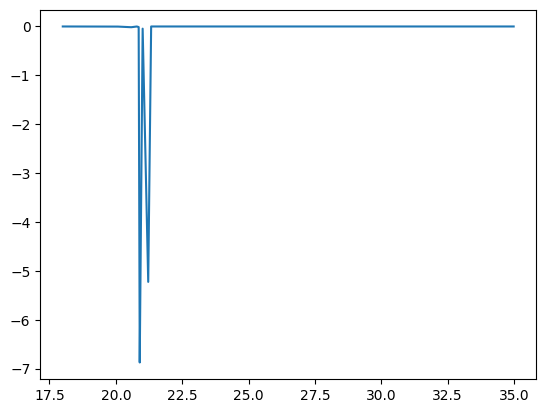

In [69]:
x = []
y = []
xs = []
ys = []
for i in range(0, len(modification_sliders_sing)):
    if modification_sliders_sing[i][0] == "U_pointer":
        modification_ctrl_pts_sing[i].sort(key=lambda x:x[0])
        for l in range(0, len(modification_ctrl_pts_sing[i])):
            x.append(modification_ctrl_pts_sing[i][l][0])
            y.append(modification_ctrl_pts_sing[i][l][1])
#             xs.append(modification_ctrl_pts[i][l][0])
#             ys.append(modification_ctrl_pts[i][l][1])
# y = np.array(y)
# plt.plot(np.where(y!=0, y, np.nan))
y_interp = interp1d(x, y, bounds_error=False, fill_value="extrapolate")
plt.plot(np.arange(18, 35, 0.01), y_interp(np.arange(18, 35, 0.01)))
# plt.plot(np.array(ys))


In [70]:
# smooth the vowel modificatoin sliders

vm_ctpt_temp = copy.deepcopy(modification_ctrl_pts_sing)
vm_slider_temp = copy.deepcopy(modification_sliders_sing) # these are references
# pass 3
# set this up
prev_slider_dict = {}
for i in range(0, len(vm_slider_temp)):
    prev_slider_dict[vm_slider_temp[i][0]+vm_slider_temp[i][1]] = -1
modification_ctrl_pts = copy.deepcopy(modification_ctrl_pts_sing) # output is stored here
modification_sliders = copy.deepcopy(modification_sliders_sing)
i = 0  
new_ctrl_pts = []
new_sliders = []
while i < len(modification_ctrl_pts):
    increment = 1
    # if the previous instance of the current viseme is not -1
    if prev_slider_dict[vm_slider_temp[i][0]+vm_slider_temp[i][1]] != -1:
        prev_i = prev_slider_dict[vm_slider_temp[i][0]+vm_slider_temp[i][1]]
        current_interval = copy.deepcopy(vm_ctpt_temp[i])
        current_interval.sort(key=lambda x:x[0])
        prev_interval = copy.deepcopy(vm_ctpt_temp[prev_i])
        prev_interval.sort(key=lambda x:x[0])
        
        # a simplified detection and merging operation:
        if current_interval[0][0] < prev_interval[-1][0]:
            temp = copy.deepcopy(prev_interval)
            prev_interval = 0
        
        # For the same vowel/consonant if the two intervals do not overlap but the onset and off set overlap 
        elif (current_interval[0][0] - prev_interval[-1][0]) <= vowel_blend_distance:
            # if we have weird overlap where the boundary of the previous interval interupts the curve of the current
#             if prev_interval[2][0] - prev_interval[1][0] <= speech_vowel_threshold:
#                 prev_interval[2][1] = 0.95 * prev_interval[1][1]
            if current_interval[1][0] <= prev_interval[-1][0] and current_interval[0][0] <= prev_interval[-2][0]:
                temp = copy.deepcopy(prev_interval)
                temp[-1][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                temp[-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
                modification_ctrl_pts[prev_i] = copy.deepcopy(temp)
                current_interval[0][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
#                 modification_ctrl_pts[i] = copy.deepcopy(current_interval)
                new_ctrl_pts.append(copy.deepcopy(current_interval))
            elif (current_interval[1][0] <= prev_interval[-1][0]):
                temp = copy.deepcopy(prev_interval)
                temp[-1][0] = current_interval[0][0]
                temp[-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
#                 visemes_sing.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]] = temp
                modification_ctrl_pts[prev_i] = copy.deepcopy(temp)
                current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
#                 visemes_sing.add(viseme_list_final[i], current_interval, pure_phoneme_list[i])
                modification_ctrl_pts[i] =  copy.deepcopy(current_interval)
            elif (current_interval[0][0] <= prev_interval[-2][0]):
                temp = copy.deepcopy(current_interval)
                temp[0][0] = prev_interval[-1][0]
                temp[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
                modification_ctrl_pts[prev_i][-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
#                 visemes_sing.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]][-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
#                 visemes_sing.add(viseme_list_final[i], temp, pure_phoneme_list[i])
                modification_ctrl_pts[i] =  copy.deepcopy(temp)
            else:
                if pure_phoneme_list[i] in cmu_sets.lip_closer:
                    pass
#                     visemes_sing.add(viseme_list_final[i], viseme_intervals_final[i], pure_phoneme_list[i])
                else:
                    temp = copy.deepcopy(prev_interval)
                    temp[-1][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                    temp[-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
#                     visemes_sing.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]] = copy.deepcopy(temp)
                    modification_ctrl_pts[prev_i] = copy.deepcopy(temp)
                    current_interval[0][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                    current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
#                     visemes_sing.add(viseme_list_final[i], current_interval, pure_phoneme_list[i])
                    modification_ctrl_pts[i] =  copy.deepcopy(current_interval)
    else:
        new_sliders.append(modification_sliders[i])
        new_ctrl_pts.append(modification_ctrl_pts[i])
        
    prev_slider_dict[vm_slider_temp[i][0]+vm_slider_temp[i][1]] = i
    i = i + increment
modification_ctrl_pts_sing = copy.deepcopy(modification_ctrl_pts)
modification_sliders_sing = copy.deepcopy(modification_sliders)

In [71]:
viseme_list = visemes_speak.viseme_list[-1]
viseme_interval = visemes_speak.viseme_ctrl_pts[-1]

modification_ctrl_pts = []
modification_sliders = []
# iterate through the vowels in the list
dt = 0.01
for i in range(0, len(viseme_list)):
    if viseme_list[i] in VOWELS_SLIDERS_JALI and viseme_interval[i][-2][0] - viseme_interval[i][0][0] > 0.30:
        ##################################################################
        ###################### get the audio signal ######################
        ##################################################################
        vowel_mod_out, vowel_mod_out_coarse = vowel_mod(lyric.sound_arr_interp(np.arange(viseme_interval[i][1][0], 
                                                                                        min(viseme_interval[i][-1][0], lyric.snd.xs()[-1]), 1.0/44100.0)))
#         print(["A", "Stretcher", "Rounder", "Silence"][vowel2Cardinal3[viseme_list[i]]])
        if  vowel_mod_out_coarse.shape[0] <= 10:
            continue
        xs = np.linspace(viseme_interval[i][1][0], min(viseme_interval[i][-1][0], lyric.snd.xs()[-1]), vowel_mod_out_coarse.shape[0])
        coarse_vowel_sounds_like_interp = interp1d(xs, vowel_mod_out_coarse, axis=0)
        
#         for i in range(0, 4):
#             plt.plot(vowel_mod_out_coarse[:, i], label=["Ah", "stretcher", "rounder", "silence"][i])
# #         plt.plot(np.argmax(out[0, :], axis=1))
#         plt.legend()
#         plt.show()
        
        # what the original sound was
        original_vowel_shape = vowel2Cardinal3[viseme_list[i]]
        only_peaks = np.where(vowel_mod_out_coarse > 0.75, vowel_mod_out_coarse, 0)
        vowel_sounds_like = np.argmax(only_peaks, axis=1)
        ##################################################################
        ### obtain the intervals of which cardinal vowels are dominant ###
        ##################################################################
        cardinal_list = []
        cardinal_intervals = []
        current_interval_start = 0
        current_vowel = original_vowel_shape
        for t in range(0, vowel_sounds_like.shape[0]):
            if vowel_sounds_like[t] == current_vowel:
                if (t == vowel_sounds_like.shape[0]-1) and current_vowel != 3:
                    cardinal_list.append(current_vowel)
                    cardinal_intervals.append([current_interval_start, t])
            else:
                if xs[t-1] - xs[current_interval_start] >= 0.1:
                    if t > 0 and current_vowel != 3:
                        cardinal_list.append(current_vowel)
                        cardinal_intervals.append([current_interval_start, t-1])
                    current_interval_start = t
                    current_vowel = vowel_sounds_like[t]
        ###########################################################################
        ######### optionally additional smoothing are added to this here ##########      
        ###########################################################################
        cardinal_list_new = []
        cardinal_intervals_new = []
        j = 0
        while j < len(cardinal_list):
            step = 1
            if j == len(cardinal_list) - 1:
                cardinal_list_new.append(cardinal_list[j])
                cardinal_intervals_new.append(cardinal_intervals[j])
            elif cardinal_list[j] == cardinal_list[j+1] and xs[cardinal_intervals[j+1][0]] - xs[cardinal_intervals[j][1]] <= spike_width:
                cardinal_list_new.append(cardinal_list[j])
                cardinal_intervals_new.append([cardinal_intervals[j][0], cardinal_intervals[j+1][1]])
                step = 2
            elif j < len(cardinal_list) - 2:
                if (cardinal_list[j] == cardinal_list[j+2] and xs[cardinal_intervals[j+2][0]] - xs[cardinal_intervals[j][1]] <= spike_width 
                    and cardinal_list[j+1] == original_vowel_shape):
                    cardinal_list_new.append(cardinal_list[j])
                    cardinal_intervals_new.append([cardinal_intervals[j][0], cardinal_intervals[j+2][1]])
                    step = 3
            else:
                cardinal_list_new.append(cardinal_list[j])
                cardinal_intervals_new.append(cardinal_intervals[j])
            j = j + step
        cardinal_list = cardinal_list_new
        cardinal_intervals = cardinal_intervals_new
#         print(cardinal_list, cardinal_intervals)
        # now set pucker/stretch values based on the detected sound
        for c in range(0, len(cardinal_list)):
            if original_vowel_shape == cardinal_list[c] or cardinal_list[c] == 3:
                continue
            else:
                max_prob = coarse_vowel_sounds_like_interp(xs[cardinal_intervals[c][0]:cardinal_intervals[c][1]+1])[:, cardinal_list[c]].max()
                
                slider_ct_pts = control_direction_matrix_coarse[original_vowel_shape][cardinal_list[c]]
                for s in range(0, int(len(slider_ct_pts)/3)):
                    ctrl_pts = []
                    # get the name and attribute of the slider
                    slider_name = slider_ct_pts[0 + 3*s]
                    if slider_name == "self":
                        slider_name = viseme_list[i]
                    slider_attribute = slider_ct_pts[1 + 3*s]
                    slider_range = slider_ct_pts[2 + 3*s]
                    # add a starting keyframe and ending keyframe
                    modification_sliders.append([slider_name, slider_attribute])
                    # the start of this curve should be earlier, e.g. at 75% of the previous interval
                    # however, if the detected modification is at the very beginning of the vowel, then it is
                    # applied the same time as the beginning of the vowel
                    same_start = False
                    if c == 0 : 
                        start = viseme_interval[i][0][0]
                        same_start = True
                    else:
                        # otherwise I choose the starting point 
                        # find the previous c that is not the current vowel
                        ci = -1
                        for ccci in range(c-1, -1, -1):
                            if original_vowel_shape != cardinal_list[ccci] and cardinal_list[ccci] != 3:
                                ci = ccci
                                break
                        if ci > -1:
#                             start_candidate = (xs[cardinal_intervals[ci][1]] - xs[cardinal_intervals[ci][0]]) * 0.6 + xs[cardinal_intervals[ci][0]]
#                             start_candidate = min(start_candidate, xs[cardinal_intervals[c][0]]-0.12)
                            start_candidate = xs[cardinal_intervals[ci][0]]-0.12
                            if viseme_interval[i][0][0] >= start_candidate:
                                same_start = True
                            start = max(start_candidate, viseme_interval[i][0][0])
                            if np.abs(start - viseme_interval[i][0][0]) <= 0.2:
                                start = viseme_interval[i][0][0]
                                same_start = True
                        else:
                            start_candidate = xs[cardinal_intervals[ci][0]]-0.12
#                             start = max(viseme_interval[i][0][0], start_candidate)
                            start = viseme_interval[i][0][0]
#                             if np.abs(start - viseme_interval[i][0][0]) <= 0.2:
#                                 start = viseme_interval[i][0][0]
#                                 same_start = True
                    ctrl_pts.append([start, slider_range[0]])
                    # add the end point of the curve. This would either at the end of the 
                    # prediction interval, or at the end of the vowel. 
#                     modification_sliders.append([slider_name, slider_attribute])
                    if c < len(cardinal_list) - 1:
                        ctrl_pts.append([xs[cardinal_intervals[c][1]] + 0.12, slider_range[0]])
                    else:
                        ctrl_pts.append([viseme_interval[i][-1][0]+0.12, slider_range[0]])        
                    # add the peaks in the middle with the decay
#                     modification_sliders.append([slider_name, slider_attribute])
                    # with some anticipation 
#                     print(slider_name, max_prob, slider_range[1])
                    if same_start:
                        ctrl_pts.append([viseme_interval[i][1][0], max_prob * (slider_range[1])])
                    else:
                        ctrl_pts.append([xs[cardinal_intervals[c][0]], max_prob * (slider_range[1])])
#                     modification_sliders.append([slider_name, slider_attribute])
                    end_p75 = (xs[cardinal_intervals[c][1]] - xs[cardinal_intervals[c][0]]) * 0.75 + xs[cardinal_intervals[c][0]]
                    ctrl_pts.append([end_p75, max_prob * (slider_range[1]) * 0.75])
                    if slider_name == "Pucker":
                        print(slider_name, ctrl_pts)
                        print(cardinal_list)
                    
                    modification_ctrl_pts.append(ctrl_pts)
modification_ctrl_pts_speak = copy.deepcopy(modification_ctrl_pts)
modification_sliders_speak = copy.deepcopy(modification_sliders)

In [72]:
vm_ctpt_temp = copy.deepcopy(modification_ctrl_pts_speak)
vm_slider_temp = copy.deepcopy(modification_sliders_speak) # these are references
# pass 3
# set this up
prev_slider_dict = {}
for i in range(0, len(vm_slider_temp)):
    prev_slider_dict[vm_slider_temp[i][0]+vm_slider_temp[i][1]] = -1

print(prev_slider_dict)
modification_ctrl_pts = copy.deepcopy(modification_ctrl_pts_speak) # output is stored here
modification_sliders = copy.deepcopy(modification_sliders_speak)
i = 0  
while i < len(modification_ctrl_pts):
    increment = 1
    # if the previous instance of the current viseme is not -1
    if prev_slider_dict[vm_slider_temp[i][0]+vm_slider_temp[i][1]] != -1:
        prev_i = prev_slider_dict[vm_slider_temp[i][0]+vm_slider_temp[i][1]]
        current_interval = copy.deepcopy(vm_ctpt_temp[i])
        current_interval.sort(key=lambda x:x[0])
        prev_interval = copy.deepcopy(vm_ctpt_temp[prev_i])
        prev_interval.sort(key=lambda x:x[0])
        # For the same vowel/consonant if the two intervals do not overlap but the onset and off set overlap 
        if (current_interval[0][0] - prev_interval[-1][0]) <= vowel_blend_distance:
            # if we have weird overlap where the boundary of the previous interval interupts the curve of the current
#             if prev_interval[2][0] - prev_interval[1][0] <= speech_vowel_threshold:
#                 prev_interval[2][1] = 0.95 * prev_interval[1][1]
            if current_interval[1][0] <= prev_interval[-1][0] and current_interval[0][0] <= prev_interval[-2][0]:
                temp = copy.deepcopy(prev_interval)
                temp[-1][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                temp[-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
                modification_ctrl_pts[prev_i] = copy.deepcopy(temp)
                current_interval[0][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
                modification_ctrl_pts[i] =  copy.deepcopy(current_interval)
            elif (current_interval[1][0] <= prev_interval[-1][0]):
                temp = copy.deepcopy(prev_interval)
                temp[-1][0] = current_interval[0][0]
                temp[-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
#                 visemes_sing.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]] = temp
                modification_ctrl_pts[prev_i] = copy.deepcopy(temp)
                current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
#                 visemes_sing.add(viseme_list_final[i], current_interval, pure_phoneme_list[i])
                modification_ctrl_pts[i] =  copy.deepcopy(current_interval)
            elif (current_interval[0][0] <= prev_interval[-2][0]):
                temp = copy.deepcopy(current_interval)
                temp[0][0] = prev_interval[-1][0]
                temp[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
                modification_ctrl_pts[prev_i][-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
#                 visemes_sing.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]][-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
#                 visemes_sing.add(viseme_list_final[i], temp, pure_phoneme_list[i])
                modification_ctrl_pts[i] =  copy.deepcopy(temp)
            else:
                if pure_phoneme_list[i] in cmu_sets.lip_closer:
#                     visemes_sing.add(viseme_list_final[i], viseme_intervals_final[i], pure_phoneme_list[i])
                    pass
                else:
                    temp = copy.deepcopy(prev_interval)
                    temp[-1][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                    temp[-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
#                     visemes_sing.viseme_ctrl_pts[-1][prev_slider_dict[viseme_list_final[i]]] = copy.deepcopy(temp)
                    modification_ctrl_pts[prev_i] = copy.deepcopy(temp)
                    current_interval[0][0] = (current_interval[0][0] + prev_interval[-1][0]) / 2.0
                    current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * vowel_blend_magnitude
#                     visemes_sing.add(viseme_list_final[i], current_interval, pure_phoneme_list[i])
                    modification_ctrl_pts[i] =  copy.deepcopy(current_interval)        
    prev_slider_dict[vm_slider_temp[i][0]+vm_slider_temp[i][1]] = i
    i = i + increment
modification_ctrl_pts_speak = copy.deepcopy(modification_ctrl_pts)
modification_sliders_speak = copy.deepcopy(modification_sliders)

{'DimpleDimple': -1, 'U_pointerlipPucker': -1, 'Eh_pointerlipCornerPull': -1, 'Eh_pointerlipStretch': -1, 'Ee_pointerlipCornerPull': -1, 'Ee_pointerlipStretch': -1, 'Oo_pointerlipPucker': -1}


## Larynx movements

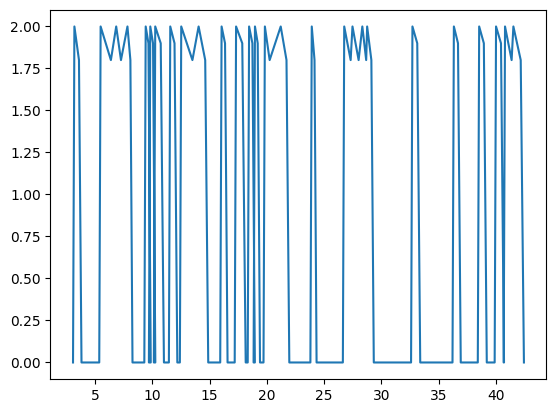

In [73]:
# viseme_list = visemes_sing.viseme_list[-1]
# viseme_ctrl_pts = visemes_sing.viseme_ctrl_pts[-1]
larynx_movements_ct_pts = []
# extended_vowel_intervals = []
# extended_vowel_list = []
in_between = False
pitch_change_intervals = []
for i in range(0, len(extended_vowel_list)):
    viseme = extended_vowel_list[i]
    if len(viseme) > 13 and viseme[-13:] == "_pitch_change":
        viseme = viseme[:-13]
        in_between = True
    else:
        in_between = False
        
    if not in_between:
        if len(pitch_change_intervals) == 0:
            curve = extended_vowel_intervals[i]
            val = 2
            throat_curve = generate_basic_viseme_curve(curve[0], curve[1], val, sustain=0.75, decay = 0.95, onset=0.12, offset=0.12)
            larynx_movements_ct_pts.append(throat_curve)
            
        else:
            throat_curve = []
            # add the onset
            throat_curve.append([pitch_change_intervals[0][0]-0.12, 0])
            for m in range(0, len(pitch_change_intervals)):
                val = 2
                throat_curve.append([pitch_change_intervals[m][0], val])
                throat_curve.append([(pitch_change_intervals[m][1] - 
                                      pitch_change_intervals[m][0]) * 0.8 + pitch_change_intervals[m][0], val*0.9])
            throat_curve.append([pitch_change_intervals[-1][1]+0.12, 0])
            pitch_change_intervals = []
            in_between = False
            larynx_movements_ct_pts.append(throat_curve)
                
    else:
        curve = extended_vowel_intervals[i]
        pitch_change_intervals.append(curve)
        
        

x = []
y = []
larynx_movements_ct_pts.sort(key=lambda x:x[0])
for i in range(0, len(larynx_movements_ct_pts)):
    for k in range(0, len(larynx_movements_ct_pts[i])):
        x.append(larynx_movements_ct_pts[i][k][0])
        y.append(larynx_movements_ct_pts[i][k][1])
plt.plot(np.array(x), np.array(y))
plt.show()

## remove overlap artifacts
i = 0  
while i < len(larynx_movements_ct_pts):
    increment = 1
    prev_viseme = viseme_list_final[i]
    # if the previous instance of the current viseme is not -1
    if i >= 1:
        current_interval = copy.deepcopy(larynx_movements_ct_pts[i])
        prev_interval = copy.deepcopy(larynx_movements_ct_pts[i-1])
        # For the same vowel/consonant if the two intervals do not overlap but the onset and off set overlap 
        if (current_interval[0][0] <= prev_interval[-1][0]):
            # if we have weird overlap where the boundary of the previous interval interupts the curve of the current
            if (current_interval[1][0] <= prev_interval[-1][0] and current_interval[0][0] <= prev_interval[-2][0]):
                larynx_movements_ct_pts[i-1] = copy.deepcopy(prev_interval[:-1])
                current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * 0.95
                current_interval[0][0] = (current_interval[0][0] + prev_interval[-2][0]) / 2
                larynx_movements_ct_pts[i] = current_interval
            elif (current_interval[1][0] <= prev_interval[-1][0]):
                larynx_movements_ct_pts[i-1] = copy.deepcopy(prev_interval[:-1])
                current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * 0.95
                current_interval[0][0] = (current_interval[0][0] + prev_interval[-2][0]) / 2
                larynx_movements_ct_pts[i] = current_interval
            elif (current_interval[0][0] <= prev_interval[-2][0]):
                larynx_movements_ct_pts[i-1][-1][1] = min(current_interval[1][1], prev_interval[-2][1]) * 0.95
                larynx_movements_ct_pts[i-1][-1][0] = (current_interval[0][0] + prev_interval[-2][0]) / 2
                larynx_movements_ct_pts[i] = copy.deepcopy(current_interval[1:])
            else:
                larynx_movements_ct_pts[i-1] = copy.deepcopy(prev_interval[:-1])
                current_interval[0][0] = (current_interval[0][0] + prev_interval[-2][0]) / 2.0
                current_interval[0][1] = min(current_interval[1][1], prev_interval[-2][1]) * 0.95
                larynx_movements_ct_pts[i] = current_interval
        # if the two interval overlaps
        elif (current_interval[1][0] <= prev_interval[-2][0]):
            interval = prev_interval[0:-2] + current_interval[1:]
            larynx_movements_ct_pts[i-1] = copy.deepcopy(interval)
#         else:
#             visemes_speak.add(viseme_list_final[i], viseme_intervals_final[i], pure_phoneme_list[i])
    else:        
#         visemes_speak.add(viseme_list_final[i], viseme_intervals_final[i], pure_phoneme_list[i])
        pass
    i = i + increment

## Output 1 Marking all the boundary points accordingly

In [74]:
M_Pnot_viseme_list = []
M_Pnot_viseme_ctrl_pts = []
M_P_viseme_list = []
M_P_viseme_ctrl_pts = []
Mnot_Pnot_viseme_list = []
Mnot_Pnot_viseme_ctrl_pts = []
Mnot_P_viseme_list = []
Mnot_P_viseme_ctrl_pts = []

for i in range(0, len(visemes_sing.viseme_list[-1])):
    M_Pnot_viseme_list.append(visemes_sing.viseme_list[-1][i])
    Mnot_P_viseme_list.append(visemes_sing.viseme_list[-1][i])
    Mnot_Pnot_viseme_list.append(visemes_sing.viseme_list[-1][i])
    M_P_viseme_list.append(visemes_sing.viseme_list[-1][i])
    ########################################################################
    # M and Pnot => boundary from visemes_sing + internal from visemes_speak
    ########################################################################
    interval = []
    for item in visemes_speak.viseme_ctrl_pts[-1][i]:
        if item[2] == "internal":
            interval.append([item[0], item[1]])
    for item in visemes_sing.viseme_ctrl_pts[-1][i]:
        if item[2] == "bound":
            interval.append([item[0], item[1]])
    M_Pnot_viseme_ctrl_pts.append(interval)
    ##########################################################################
    # M not and P => boundary from visemes_speak + internal from visemes_sing#
    ##########################################################################
    interval = []
    for item in visemes_sing.viseme_ctrl_pts[-1][i]:
        if item[2] == "internal":
            interval.append([item[0], item[1]])
    for item in visemes_speak.viseme_ctrl_pts[-1][i]:
        if item[2] == "bound":
            interval.append([item[0], item[1]])
    
    Mnot_P_viseme_ctrl_pts.append(interval)
    ##########################################################################
    # M not and P not => boundary from visemes_speak + internal from visemes_speak
    ##########################################################################
    interval = []
    for item in visemes_speak.viseme_ctrl_pts[-1][i]:
        interval.append([item[0], item[1]])
    Mnot_Pnot_viseme_ctrl_pts.append(interval)
    ##########################################################################
    # M and P => boundary from visemes_speak + internal from visemes_sing
    ##########################################################################
    interval = []
    for item in visemes_sing.viseme_ctrl_pts[-1][i]:
        interval.append([item[0], item[1]])
    M_P_viseme_ctrl_pts.append(interval)    

In [75]:
output ={"M_Pnot_viseme":[M_Pnot_viseme_list, M_Pnot_viseme_ctrl_pts],
         "M_P_viseme":[M_P_viseme_list, M_P_viseme_ctrl_pts],
         "Mnot_Pnot_viseme":[Mnot_Pnot_viseme_list, Mnot_Pnot_viseme_ctrl_pts],
         "Mnot_P_viseme":[Mnot_P_viseme_list, Mnot_P_viseme_ctrl_pts],
#         "brow":[brow_movement, brow_ctrl_points, finer_brow_raise_ctrl_points, finer_brow_furrow_ctrl_points],
         
#         "blink":[eye_movement, eye_ctrl_points],
        "vowel_mod_M": [modification_sliders_sing, modification_ctrl_pts_sing],
        "vowel_mod_M_not": [modification_sliders_speak, modification_ctrl_pts_speak],
        "throat": larynx_movements_ct_pts,
        "jaw":[[0, 6]],
        "lip":[[0, 6]], 
        "vib":vib_ctrl_pts}
jsonoutput = json.dumps(output)
with open(os.path.join(dir, file_name_template+ '.json'), 'w') as outfile:
    json.dump(jsonoutput, outfile)
os.path.join(dir, file_name_template+ '.json')

'C:/Users/evan1/Desktop/music_companion\\someone_like_you.json'